# Cluster Analysis

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("./data/agg_all.csv", index_col=0)
df

,Total,A,B,C,D,Study
0,7.666667,0.080000,0.060000,0.020000,0.473333,Fridberg
1,-4.500000,0.160000,0.173333,0.080000,0.220000,Fridberg
2,-5.000000,0.080000,0.233333,0.066667,0.253333,Fridberg
3,-3.500000,0.073333,0.226667,0.080000,0.253333,Fridberg
4,0.666667,0.066667,0.160000,0.100000,0.306667,Fridberg
...,...,...,...,...,...,...
93,2.000000,0.160000,0.460000,0.086667,0.293333,Wetzels
94,14.333333,0.033333,0.206667,0.306667,0.453333,Wetzels
95,9.666667,0.120000,0.126667,0.246667,0.506667,Wetzels
96,8.000000,0.166667,0.200000,0.293333,0.340000,Wetzels


100 has most studies, 95 has 1 and 150 in between.
if i do totals of each picked and amount won for each dataset and normalise the amount of number of trials and decks picked over total picks.

could also look at if its really after 50th trial they start to go one way or the other.

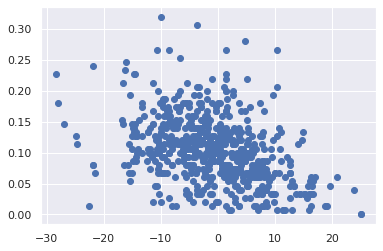

In [3]:
plt.scatter(df['Total'], df['A'])
# plt.xlim(-180,180)
# plt.ylim(-90,90)
plt.show()

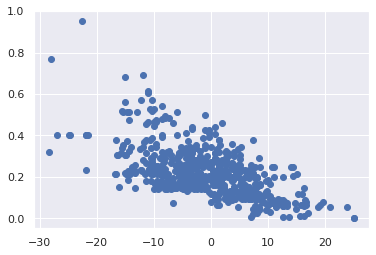

In [4]:
plt.scatter(df['Total'], df['B'])
# plt.xlim(-180,180)
# plt.ylim(-90,90)
plt.show()

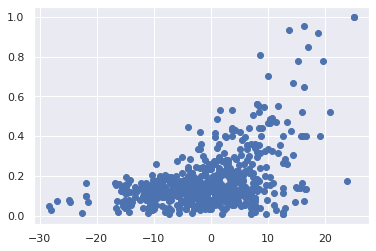

In [5]:
plt.scatter(df['Total'], df['C'])
# plt.xlim(-180,180)
# plt.ylim(-90,90)
plt.show()

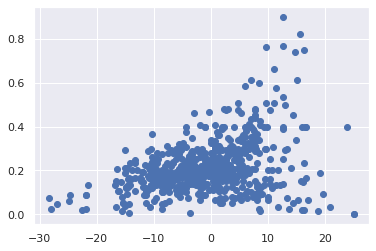

In [6]:
plt.scatter(df['Total'], df['D'])
# plt.xlim(-180,180)
# plt.ylim(-90,90)
plt.show()

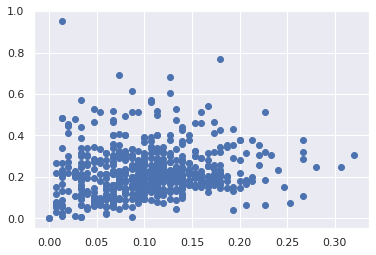

In [7]:
plt.scatter(df['A'], df['B'])
plt.show()

In [8]:
x = df.iloc[:,:2] # 1t for rows and second for columns
x

,Total,A
0,7.666667,0.080000
1,-4.500000,0.160000
2,-5.000000,0.080000
3,-3.500000,0.073333
4,0.666667,0.066667
...,...,...
93,2.000000,0.160000
94,14.333333,0.033333
95,9.666667,0.120000
96,8.000000,0.166667


In [9]:
kmeans = KMeans(3)
kmeans.fit(x)

KMeans(n_clusters=3)

In [10]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 2, 2,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 1,
       1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 1,
       1, 0, 2, 2, 0, 0, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2,
       0, 1, 0, 1, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0,
       2, 2, 2, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1,
       0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1,
       2, 0, 1, 1, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0,
       2, 2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1,

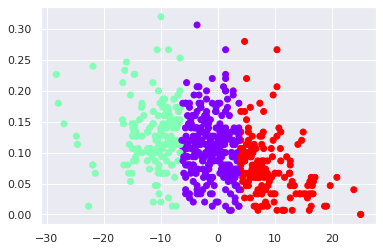

In [11]:
data_with_clusters = df.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['Total'],data_with_clusters['A'],c=data_with_clusters['Clusters'],cmap='rainbow')


In [12]:
y = df.iloc[:,[0,2]] # 1t for rows and second for columns
y

,Total,B
0,7.666667,0.060000
1,-4.500000,0.173333
2,-5.000000,0.233333
3,-3.500000,0.226667
4,0.666667,0.160000
...,...,...
93,2.000000,0.460000
94,14.333333,0.206667
95,9.666667,0.126667
96,8.000000,0.200000


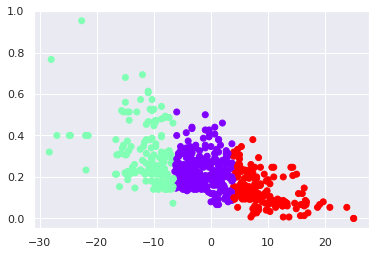

In [13]:
kmeans = KMeans(3)
kmeans.fit(x)
data_with_clusters = df.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['Total'],data_with_clusters['B'],c=data_with_clusters['Clusters'],cmap='rainbow')


array([2, 0, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2,
       0, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 2, 0, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2,
       2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2,
       2, 2, 2, 0, 2, 1, 2, 1, 0, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 1,
       2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 2,
       2, 0, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2,
       1, 1, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 2,